In [2]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [3]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument('--ignore-certificate-errors')
chrome_options.add_argument('--incognito')
driver = webdriver.Chrome(options=chrome_options)

In [4]:
book_shelves = []
for i in range(1,69):
    book_shelf = driver.get(f"https://www.idefix.com/kategori/Kitap/Bilim/grupno=00052?Page={i}")
    html_content = driver.page_source
    book_shelves.append(html_content)
    time.sleep(0.5)

In [5]:
book_links = []
for page in book_shelves:
    soup = BeautifulSoup(page, "html.parser")
    links = soup.find_all('div', attrs={"class": "product-info"})
    for link in links:
        book_links.append(link.find_all('div', attrs={"class": "box-title"})[0].a.get('href'))

In [6]:
book_pages = []
for link in book_links:
    book_page = driver.get(f"https://www.idefix.com/{link}")
    html_content = driver.page_source
    book_pages.append(html_content)
    time.sleep(0.05)

In [8]:
name_list = []
author_list = []
price_list = []
number_of_reviwer_list = []
rate_list = []
publication_year_list = []
number_of_page_list = []

for i in range(0,len(book_pages)):
    html_content = book_pages[i]
    soup = BeautifulSoup(html_content, "html.parser")
    try:
        name = soup.find_all('a', attrs={"class": "bold"})[0].text
    except AttributeError:
        name = "N/A"
    try:
        author = soup.find('div', attrs={"class": "author"}).find('a').text
    except AttributeError:
        author = "N/A"
    try:
        price = float(format(float(soup.find('div', attrs={"id": "salePrice"}).text.split("TL")[0].replace(',', ''))/ 100, '.02f'))
    except AttributeError:
        price = 0
    except IndexError:
        price = 0
    try:
        number_of_reviwers = soup.find('div', attrs={"class": "review-container"}).find("span").text.split(" ")[-2]
    except AttributeError:
        number_of_reviwers = ""
    try:
        rate = soup.find('div', attrs={"class": "review-container"}).find("span").find_next().text.strip()
        if "," in rate:
            rate = rate.replace(',', '.')
            rate = float(rate)
    except AttributeError:
        rate = ""
    try:
        publication_year =  soup.find("span", text=re.compile("İlk Baskı Yılı:")).find_next().get_text(strip=True)
    except AttributeError:
        publication_year = ""
    try:
        number_of_pages =  soup.find("span", text=re.compile("Sayfa Sayısı:")).find_next().get_text(strip=True)
    except AttributeError:
        number_of_pages = ""
    name_list.append(name)
    author_list.append(author)
    price_list.append(price)
    number_of_reviwer_list.append(number_of_reviwers)
    rate_list.append(rate)
    publication_year_list.append(publication_year)
    number_of_page_list.append(number_of_pages)

In [9]:
book_dictionary = {"name":name_list,
             "author":author_list,
             "price":price_list,
             "number_of_review":number_of_reviwer_list,
             "rate":rate_list,
             "publication_year":publication_year_list,
             "number_of_page":number_of_page_list}

In [10]:
import json
books_json = json.dumps(book_dictionary)
with open("book_list.json", "w") as outfile:
    outfile.write(books_json)

In [11]:
json_file = open ('book_list.json', "r")
file_data = json.loads(json_file.read())
json_file.close()

In [12]:
book_df = pd.DataFrame()

In [14]:
book_df["name"] = file_data["name"]
book_df["author"] = file_data["author"]
book_df["price"] = file_data["price"]
book_df["number_of_review"] = file_data["number_of_review"]
book_df["rate"] = file_data["rate"]
book_df["publication_year"] = file_data["publication_year"]
book_df["number_of_page"] = file_data["number_of_page"]

In [15]:
book_df.head()

,name,author,price,number_of_review,rate,publication_year,number_of_page
0,Tehlikeli Tırmanış,Hakan Bulgurlu,41.28,1,4,2021,240
1,Ağaçların Gizli Yaşamı,Peter Wohlleben,31.85,16,4,2018,247
2,Beyinde Ararken Bağırsakta Buldum,Serkan Karaismailoğlu,27.30,78,3.5,2017,
3,Yeni Dünyanın Cesur İnsanı,Sinan Canan,34.00,0,0,2021,176
4,Yeni Bilim: Bağlantısallık - Yeni Kültür: Yaşa...,Türker Kılıç,20.80,10,3.5,2021,192


In [16]:
book_df.describe()

,price
count,2447.000000
mean,41.590196
std,35.485785
min,0.000000
25%,23.605000
50%,33.000000
75%,46.240000
max,487.950000


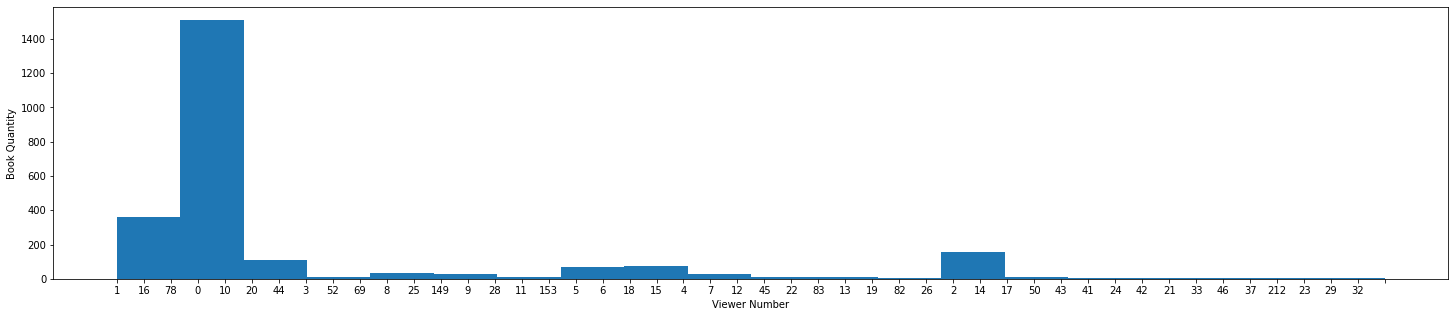

In [18]:
figure = plt.figure(figsize=(25,5))
plt.hist(book_df["number_of_review"] ,bins=20)
plt.xlabel("Viewer Number")
plt.ylabel("Book Quantity")
plt.show()